/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


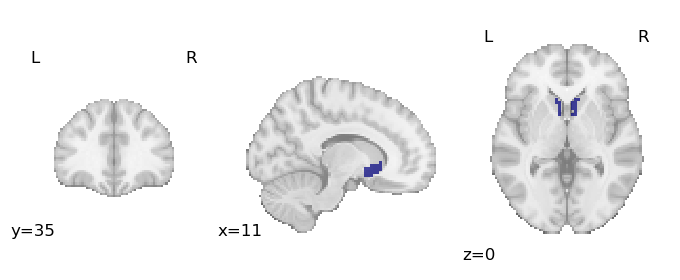

,Subject,Ones,Composite_Reward,Composite_Reward_Squared,tsnr,fd_mean
0,sub-1001,1,0.469388,0.220325,-0.379745,0.030117
1,sub-1002,1,-1.530612,2.342774,1.099834,-1.142999
2,sub-1003,1,0.469388,0.220325,-0.114737,0.105981
3,sub-1004,1,2.469388,6.097876,-0.076754,-0.474856
4,sub-1006,1,-0.530612,0.281549,1.360129,-0.870765


In [1]:
import os 
import pandas as pd
from nilearn import plotting, input_data
import matplotlib.pyplot as plt
import seaborn as sms
import re
import numpy as np

#Save Text as text
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
plt.rcParams.update(new_rc_params)

task='mid'

mask='../masks/seed-VS.nii.gz'
plotting.plot_roi(mask,draw_cross=False,cut_coords=[11.5,35.5,-0.5])
vs_masker=input_data.NiftiMasker(mask_img=mask)
plt.show()

fsl_data='/data/projects/istart-%s/derivatives/fsl'%(task)


df=pd.read_excel('../derivatives/covariates/final_output_composite.xls')
df=df.iloc[:47,:]
df.dropna(axis=1,inplace=True)
df['Subject'] = 'sub-' + df['Subject'].astype(str)
df.head()

# Correlation Between Reward Sensitivity and Subst.Use

In [3]:
#sms.lmplot(x='Composite_Reward',y='Composite_Substance',data=df,order=2)
#from scipy.stats import pearsonr
#r,p=pearsonr(x=df['Composite_Reward_Squared'],y=df['Composite_Substance'])
#print("Correlation R^2:%s p: %s"%(r**2,p))

## Collecting VS activation for Each subject

In [11]:
x=[x for x in os.listdir('../derivatives/fsl/sub-1015') if 'act_run' in x]
x=[d for d in x if 'model-4' in d]
x

['L1_task-mid_model-4_type-act_run-2.feat',
 'L1_task-mid_model-4_type-act_run-1.feat']

In [4]:
data=[]
cope_map={1:'Large Gain', 2: 'Small Gain',
          3: 'Large Loss', 4: 'Small Loss', 5: 'Hit',
         6:'Miss',7:'Neutral',8:'Gain>Loss',9:'Gain>Neut',
         10:'Loss>Neut',11:'Salience',12:'Hit-Miss',
          13:'LG-SG',14:'LL-SL'}
print(df['Fnames-act'][0])
for fname in df['Fnames-act']:
    sub=re.search('fsl/(.*)/L',fname).group(1)
    level=re.search('sub-..../(.*)_task',fname).group(1)
    activations=[]
    cope_list=[]
    for cope in [8,9,10,11,12,13,14]:
        
        if level=='L1':
            image='%s/%s/L1_task-mid_model-1_type-act_run-1.feat/stats/cope%s.nii.gz'%(
            fsl_data,sub,cope)
        if level=='L2':
            image='%s/%s/L2_task-mid_model-1_type-act.gfeat/cope%s.feat/stats/cope1.nii.gz'%(
            fsl_data,sub,cope)
        
        act_value_array=vs_masker.fit_transform(image)
        act_value=np.mean(act_value_array)
        activations.append(act_value)
        cope_list.append(cope)
    data.append([sub]+activations)

neuro_df=pd.DataFrame(data=data,columns=['Subject','Act Gain>Loss','Act Gain>Neut',
         'Act Loss>Neut','Act Salience','Act Hit-Miss','Act LG-SG','Act LL-SL'])
big_df=pd.merge(df,neuro_df,on='Subject')
display(big_df.head())
plotting.plot_roi(vs_masker.mask_img_,draw_cross=False)


KeyError: 'Fnames-act'

In [ ]:
big_df.head()
big_df.to_csv("For_David_VSAct.tsv",sep='\t',index=False)

## Reward Sensitivity and VS Activation

In [ ]:
copes=[col for col in big_df.columns if col.startswith('Act')]
for col in copes:
    r,p=pearsonr(big_df['Composite_Reward'],big_df[col])
    print("Correlation between %s and Composite Reward: \n R^2 %s p: %s"%(
    col,r**2,p))
    sms.lmplot(x='Composite_Reward',y=col,
               data=big_df)
    plt.show()
    r,p=pearsonr(big_df['Composite_Reward_Squared'],big_df[col])
    print("Correlation between %s and Squared Composite Reward: \n R^2 %s p: %s"%(
    col,r**2,p))
    sms.lmplot(x='Composite_Reward',y=col,
               data=big_df,order=2)
    plt.show()

## Substance Use and VS Activation

In [ ]:
copes=[col for col in big_df.columns if col.startswith('Act')]
for col in copes:
    r,p=pearsonr(big_df['Composite_Substance'],big_df[col])
    print("Correlation between %s and Substance Use: \n R^2 %s p: %s"%(
    col,r**2,p))
    sms.lmplot(x='Composite_Substance',y=col,
               data=big_df)
    plt.show()
    #r,p=pearsonr(big_df['Composite_Reward_Squared'],big_df[col])
    #print("Correlation between %s and Composite Reward: \n R^2 %s p: %s"%(
    #col,r,p))
    #sms.lmplot(x='Composite_Reward',y=col,
    #           data=big_df,order=2)
    #plt.show()

## Interaction with Substance Use


In [ ]:
big_df["Low_Substance"] = (big_df.Composite_Substance<df.Composite_Substance.quantile()).replace({True:'Low', False:'High'})

In [ ]:
copes=[col for col in big_df.columns if col.startswith('Act')]
for col in copes:
    r,p=pearsonr(big_df['Composite_Reward'],big_df[col])
    print("Correlation between %s and Composite Reward: \n R^2 %s p: %s"%(
    col,r**2,p))
    sms.lmplot(x='Composite_Reward',y=col,hue='Low_Substance',
               data=big_df)
    plt.show()
    r,p=pearsonr(big_df['Composite_Reward_Squared'],big_df[col])
    print("Correlation between %s and Squared Composite Reward: \n R^2 %s p: %s"%(
    col,r**2,p))
    sms.lmplot(x='Composite_Reward',y=col,hue='Low_Substance',
               data=big_df,order=2)
    plt.show()

# PscyhoPhysiological Interactions

In [ ]:
cope=15
mpfc_coords=[(3,45,-5)]
basedir='../derivatives/fsl/L3_model-1_task-mid_n48_flame1/'
#print(os.listdir(basedir))
res_dir=[basedir+d for d in os.listdir(basedir)if ('ppi'in d) & (f'cnum-{cope:02}_'in d)&('INTs-wInt'in d)]
res_dir=res_dir[0]
#print(os.listdir(res_dir+'/cope1.feat'))
for cope in range(1):
    cope=cope+1
    display=plotting.plot_stat_map(res_dir+f'/cope1.feat/thresh_zstat{cope}.nii.gz',threshold=6,
                           cut_coords=[3,45,-5],draw_cross=False)
    display.add_markers(marker_coords=mpfc_coords, marker_color='b',
                    marker_size=300)
    plt.show()
    

In [ ]:

data=[]
cope_map={1:'Large Gain', 2: 'Small Gain',
          3: 'Large Loss', 4: 'Small Loss', 5: 'Hit',
         6:'Miss',7:'Neutral',8:'Gain>Loss',9:'Gain>Neut',
         10:'Loss>Neut',11:'Salience',12:'Hit-Miss',
          13:'LG-SG',14:'LL-SL'}
print(df['Fnames-act'][0])
for fname in df['Fnames-act']:
    sub=re.search('fsl/(.*)/L',fname).group(1)
    level=re.search('sub-..../(.*)_task',fname).group(1)
    activations=[]
    cope_list=[]
    display(sub)
    for cope in [8,9,10,11,12,13,14]:
        
        if level=='L1':
            image='%s/%s/L1_task-mid_model-1_type-ppi_seed-NAcc_run-1_sm-.feat/stats/cope%s.nii.gz'%(
            fsl_data,sub,cope)
        if level=='L2':
            image='%s/%s/L2_task-mid_model-1_type-ppi_seed-NAcc.gfeat/cope%s.feat/stats/cope1.nii.gz'%(
            fsl_data,sub,cope)
        
        act_value_array=sphere_masker.fit_transform(image)
        act_value=np.mean(act_value_array)
        activations.append(act_value)
        cope_list.append(cope)
    data.append([sub]+activations)

conn_df=pd.DataFrame(data=data,columns=['Subject','Conn Gain>Loss','Conn Gain>Neut',
         'Conn Loss>Neut','Conn Salience','Conn Hit-Miss','Conn LG-SG','Conn LL-SL'])
big_df=pd.merge(big_df,conn_df,on='Subject')
display(big_df.head())

In [ ]:
big_df.head()
big_df.to_csv("For_David_VSAct_ConnOFC_2-46--8.tsv",sep='\t',index=False)

## Reward Sensitivity and OFC Connections

In [ ]:
copes=[col for col in big_df.columns if col.startswith('Conn')]
for col in copes:
    r,p=pearsonr(big_df['Composite_Reward'],big_df[col])
    print("Correlation between %s and Composite Reward: \n R^2 %s p: %s"%(
    col,r,p))
    sms.lmplot(x='Composite_Reward',y=col,
               data=big_df)
    plt.show()
    
    r,p=pearsonr(big_df['Composite_Reward_Squared'],big_df[col])
    print("Correlation between %s and Squared Composite Reward: \n R^2 %s p: %s"%(
    col,r,p))
    sms.lmplot(x='Composite_Reward',y=col,
               data=big_df,order=2)
    plt.show()

## Interaction with Substance Use


In [ ]:
copes=[col for col in big_df.columns if col.startswith('Conn')]
for col in copes:
    r,p=pearsonr(big_df['Composite_Reward'],big_df[col])
    print("Correlation between %s and Composite Reward: \n R^2 %s p: %s"%(
    col,r,p))
    sms.lmplot(x='Composite_Reward',y=col,hue='Low_Substance',
               data=big_df)
    plt.show()
    r,p=pearsonr(big_df['Composite_Reward_Squared'],big_df[col])
    print("Correlation between %s and Squared Composite Reward: \n R^2 %s p: %s"%(
    col,r,p))
    sms.lmplot(x='Composite_Reward',y=col,hue='Low_Substance',
               data=big_df,order=2)
    plt.show()

In [ ]:
plotting.view_img(res_dir+f'/cope1.feat/thresh_zstat{cope}.nii.gz',threshold=6.5,draw_cross=False)


## Other Masks


In [ ]:
import os
from scipy.stats import pearsonr, spearmanr
masks=['../masks/'+mask for mask in os.listdir('../masks') if mask.startswith('conn_')]
#masks=[f for f in masks if 'rightVS_dACC' in f]
for mask in masks: # Looping through all of David's requested masks
    roi=re.search("conn_(.*).nii.gz",mask).group(1)
    print("Mask =%s"%(mask))
    plotting.plot_roi(mask,draw_cross=False,cut_coords=[11.5,35.5,-0.5])
    vs_masker=input_data.NiftiMasker(mask_img=mask)
    plt.show()
    
    data=[] #looping through all of the connectivity analyses
    for fname in df['Fnames-act']:
        sub=re.search('fsl/(.*)/L',fname).group(1)
        level=re.search('sub-..../(.*)_task',fname).group(1)
        activations=[]
        cope_list=[]
        for cope in [8,9,10,11,12,13,14]:#Looping through all of the contrasts

            if level=='L1':#Seperating out if they have only 1 or 2 runs
                image='%s/%s/L1_task-mid_model-1_type-ppi_seed-NAcc_run-1_sm-.feat/stats/cope%s.nii.gz'%(
                fsl_data,sub,cope)
            if level=='L2':
                image='%s/%s/L2_task-mid_model-1_type-ppi_seed-NAcc.gfeat/cope%s.feat/stats/cope1.nii.gz'%(
                fsl_data,sub,cope)

            act_value_array=vs_masker.fit_transform(image)
            act_value=np.mean(act_value_array)
            activations.append(act_value)
            cope_list.append(cope)
        data.append([sub]+activations)

    conn_df=pd.DataFrame(data=data,columns=['Subject','Conn Gain>Loss','Conn Gain>Neut',
             'Conn Loss>Neut','Conn Salience','Conn Hit-Miss','Conn LG-SG','Conn LL-SL'])
    big_df.to_csv("ForDavid_customMasks_%s.tsv"%(roi),sep='\t')
    big_df=pd.merge(df,conn_df,on='Subject')
    display(big_df.head())
    copes=[col for col in big_df.columns if col.startswith('Conn')]
    for col in copes:
        r,p=pearsonr(big_df['Composite_Reward'],big_df[col])
        print("Correlation between %s and Composite Reward: \n R^2 %s p: %s"%(
        col,r**2,p))
        sms.lmplot(x='Composite_Reward',y=col,
                   data=big_df)
        plt.savefig("figures/VSConn_mask-%s_Contr-%s.svg"%(roi,col))
        plt.show()

        r,p=pearsonr(big_df['Composite_Reward_Squared'],big_df[col])
        print("Correlation between %s and Squared Composite Reward: \n R^2 %s p: %s"%(
        col,r**2,p))
        sms.lmplot(x='Composite_Reward',y=col,
                   data=big_df,order=2)
        plt.show()

In [ ]:
masks=['../masks/'+mask for mask in os.listdir('../masks') if mask.startswith('conn_')]
print(masks)


In [ ]:
masks